In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import re
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

In [0]:
import os
os.chdir('/content/drive/My Drive/5153 project/')

In [0]:
df = pd.read_csv('random_3000_with_label.csv')

In [0]:
df.head()

,Index,user_id,created_at,content,like_num,repost_num,comment_num,manually_label,sentiment_baseline,senti_by_refined_snownlp,senti_by_jieba_sentiment
0,10289,2670985301,2020-02-08 23:52,抗击疫情 我们誓死不退（祝洛东） #武汉加油##抗击新型肺炎我们在行动##抗疫行动##万众...,6,0,0,1,1,1,1
1,33252,5622277724,2020-03-06 23:22,#甘肃新增17例境外输入新冠肺炎# 又来[费解]晕死真的是,1,0,1,0,-1,-1,1
2,15869,5936449524,2020-02-15 23:54,#新冠肺炎已开始在日本流行# 我靠,0,0,0,0,0,0,1
3,14422,2211096821,2020-02-13 23:59,日本再确诊1例新冠肺炎病例 总确诊数已达251例 http://t.cn/A6hGfqoZ,0,0,0,0,-1,-1,1
4,23309,6303064815,2020-02-23 23:59,//@微博辟谣:#微博辟谣# 金银潭医院：军运会五外籍运动员患的都是疟疾，与新冠肺炎无关,0,0,0,0,1,-1,1


In [0]:
df.drop(['sentiment_baseline','senti_by_refined_snownlp','senti_by_jieba_sentiment'],axis=1,inplace=True)
df.head()

,Index,user_id,created_at,content,like_num,repost_num,comment_num,manually_label
0,10289,2670985301,2020-02-08 23:52,抗击疫情 我们誓死不退（祝洛东） #武汉加油##抗击新型肺炎我们在行动##抗疫行动##万众...,6,0,0,1
1,33252,5622277724,2020-03-06 23:22,#甘肃新增17例境外输入新冠肺炎# 又来[费解]晕死真的是,1,0,1,0
2,15869,5936449524,2020-02-15 23:54,#新冠肺炎已开始在日本流行# 我靠,0,0,0,0
3,14422,2211096821,2020-02-13 23:59,日本再确诊1例新冠肺炎病例 总确诊数已达251例 http://t.cn/A6hGfqoZ,0,0,0,0
4,23309,6303064815,2020-02-23 23:59,//@微博辟谣:#微博辟谣# 金银潭医院：军运会五外籍运动员患的都是疟疾，与新冠肺炎无关,0,0,0,0


In [0]:
content_list = []
for comm in df.content.tolist():
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)','',comm)
    text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',text)
    r='[’！？：；【】，、《》!"#$%&\'()（）“”…*+,-./:;<=>?@[\\]^_`{|}~]+'
    text = re.sub(r, '', text)
    content_list.append(text)

In [0]:
df['content'] = content_list

In [0]:
import jieba
df['content'] = df['content'].apply(lambda i:jieba.cut(i) )
df['content'] =[' '.join(i) for i in df['content']]
df.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.979 seconds.
Prefix dict has been built successfully.


,Index,user_id,created_at,content,like_num,repost_num,comment_num,manually_label
0,10289,2670985301,2020-02-08 23:52,抗击 疫情 我们 誓死 不退 祝 洛东 武汉 加油 抗击 新型 肺炎 我们 在 ...,6,0,0,1
1,33252,5622277724,2020-03-06 23:22,甘肃 新增 17 例 境外 输入 新冠 肺炎 又 来 晕死 真的 是,1,0,1,0
2,15869,5936449524,2020-02-15 23:54,新冠 肺炎 已 开始 在 日本 流行 我 靠,0,0,0,0
3,14422,2211096821,2020-02-13 23:59,日本 再 确诊 1 例新冠 肺炎 病例 总 确诊 数已 达 251 例,0,0,0,0
4,23309,6303064815,2020-02-23 23:59,微博 辟谣 金银 潭 医院 军运会 五 外籍 运动员 患 的 都 是 疟疾 与 新冠 肺...,0,0,0,0


In [0]:
y = df.manually_label.values
x_train, x_valid, y_train, y_valid = train_test_split(df.content.values, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)
print (x_train.shape)
print (x_valid.shape)

(2400,)
(600,)


In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [0]:
def number_normalizer(tokens):
    """ 将所有数字标记映射为一个占位符（Placeholder）。
    对于许多实际应用场景来说，以数字开头的tokens不是很有用，
    但这样tokens的存在也有一定相关性。 通过将所有数字都表示成同一个符号，可以达到降维的目的。
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super(NumberNormalizingVectorizer, self).build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

stwlist=[line.strip() for line in open('cn_stopwords.txt',
'r',encoding='utf-8').readlines()]
tfv = NumberNormalizingVectorizer(min_df=3,  
                                  max_df=0.5,
                                  max_features=None,                 
                                  ngram_range=(1,2), 
                                  use_idf=True,
                                  smooth_idf=True,
                                  stop_words = stwlist)

tfv.fit(list(x_train) + list(x_valid))
x_train_tfv =  tfv.transform(x_train) 
x_valid_tfv = tfv.transform(x_valid)

#### Bayes

In [0]:
clf = MultinomialNB()
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.765 
              precision    recall  f1-score   support

          -1       0.72      0.43      0.54       161
           0       0.62      0.85      0.72       258
           1       0.73      0.60      0.66       181

    accuracy                           0.66       600
   macro avg       0.69      0.63      0.64       600
weighted avg       0.68      0.66      0.65       600



#### Logistic Regression

In [0]:
clf = LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial')
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.633 
              precision    recall  f1-score   support

          -1       0.64      0.53      0.58       161
           0       0.64      0.79      0.71       258
           1       0.76      0.61      0.68       181

    accuracy                           0.67       600
   macro avg       0.68      0.65      0.66       600
weighted avg       0.68      0.67      0.67       600



#### SVM

In [0]:
%%time
clf = SVC(C=1.0,kernel='rbf',probability=True)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.918 
              precision    recall  f1-score   support

          -1       0.60      0.47      0.52       161
           0       0.60      0.79      0.68       258
           1       0.74      0.56      0.64       181

    accuracy                           0.63       600
   macro avg       0.65      0.61      0.62       600
weighted avg       0.64      0.63      0.63       600

CPU times: user 11.2 s, sys: 739 µs, total: 11.2 s
Wall time: 11.3 s


#### XGBoost

In [0]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 2.094 
              precision    recall  f1-score   support

          -1       0.61      0.52      0.56       161
           0       0.64      0.77      0.70       258
           1       0.73      0.61      0.66       181

    accuracy                           0.66       600
   macro avg       0.66      0.63      0.64       600
weighted avg       0.66      0.66      0.65       600



Bagging Classifier on Logistic Regression

In [0]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial'),n_estimators=10, random_state=0)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.599 
              precision    recall  f1-score   support

          -1       0.66      0.52      0.58       161
           0       0.63      0.81      0.71       258
           1       0.77      0.60      0.67       181

    accuracy                           0.67       600
   macro avg       0.69      0.64      0.66       600
weighted avg       0.68      0.67      0.66       600



Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.156 
              precision    recall  f1-score   support

          -1       1.00      0.01      0.01       161
           0       0.43      1.00      0.60       258
           1       1.00      0.02      0.03       181

    accuracy                           0.44       600
   macro avg       0.81      0.34      0.22       600
weighted avg       0.76      0.44      0.27       600



Adaboost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 1.109 
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       161
           0       0.60      0.72      0.65       258
           1       0.69      0.56      0.62       181

    accuracy                           0.60       600
   macro avg       0.61      0.58      0.59       600
weighted avg       0.61      0.60      0.60       600



#### LightGBM

In [0]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(max_depth=7, n_estimators=500, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(x_train_tfv, y_train)
y_pred_proba = clf.predict_proba(x_valid_tfv)
y_pred = clf.predict(x_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred,target_names = ['-1','0','1']))

logloss: 2.724 
              precision    recall  f1-score   support

          -1       0.59      0.54      0.56       161
           0       0.64      0.73      0.68       258
           1       0.70      0.61      0.65       181

    accuracy                           0.64       600
   macro avg       0.64      0.63      0.63       600
weighted avg       0.64      0.64      0.64       600



#### Prediction for the whole dataset

In [0]:
df_all = pd.read_csv('df_final.csv',encoding='utf-8')
df_all = df_all[(df_all.content != '转发微博')&(df_all.content != 'repost')&(df_all.content != '')]
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)

In [0]:
df_all

,user_id,created_at,content,like_num,repost_num,comment_num
0,1681872675,2020-01-20 08:10,发现满屏都是关于新冠肺炎在全国各地传播的新闻，虽可控可防，但还是觉得可怕，不禁想起09年非典...,0,0,0
1,1306052985,2020-01-20 08:21,三条通报的时间点好一致//首发症状大多为发热、咳嗽、胸闷、呼吸困难，这新冠肺炎还挺厉害的……,0,0,0
2,2218332387,2020-01-20 09:08,关于最近很猖狂的新冠型肺炎病毒 我们紧急召开了第二届家庭会议 与会人员：我、谢胖子 会议主题...,0,1,3
3,2167644005,2020-01-20 13:49,有过上海世博会的经历，各种排队不是个事儿。有过非典型肺炎的经验，武汉新冠也不会恐慌。,0,0,0
4,7339096067,2020-01-20 18:34,#星座[超话]# 仔细想想，自打1.12土冥合相之后就没什么好消息啊…叹气 更不用说这两天突...,4,0,7
...,...,...,...,...,...,...
36650,1804649801,2020-03-09 23:59,#西班牙新冠肺炎确诊病例已达999例# 愿平安！🙏🙏,1,0,0
36651,5344250889,2020-03-09 23:59,【巩固拓展决胜态势，坚决打赢两场硬仗！徐衣显在这场专题新闻发布会上透漏了……】昨日下午，河南...,0,0,0
36652,5094666244,2020-03-09 23:59,#钟南山院士公布研究最新成果# 【钟南山院士：已开发快速检测试纸、恒温扩增芯片两个新方法 助...,0,2,0
36653,5109213891,2020-03-09 23:59,【李克强主持召开中央应对新冠肺炎疫情工作领导小组会议】3月9日，中共中央政治局常委、国务院总...,0,0,0


In [0]:
df.set_index('Index',inplace=True)
df.head()

,user_id,created_at,content,like_num,repost_num,comment_num,manually_label
Index,,,,,,,
10289,2670985301,2020-02-08 23:52,抗击 疫情 我们 誓死 不退 祝 洛东 武汉 加油 抗击 新型 肺炎 我们 在 ...,6,0,0,1
33252,5622277724,2020-03-06 23:22,甘肃 新增 17 例 境外 输入 新冠 肺炎 又 来 晕死 真的 是,1,0,1,0
15869,5936449524,2020-02-15 23:54,新冠 肺炎 已 开始 在 日本 流行 我 靠,0,0,0,0
14422,2211096821,2020-02-13 23:59,日本 再 确诊 1 例新冠 肺炎 病例 总 确诊 数已 达 251 例,0,0,0,0
23309,6303064815,2020-02-23 23:59,微博 辟谣 金银 潭 医院 军运会 五 外籍 运动员 患 的 都 是 疟疾 与 新冠 肺...,0,0,0,0


In [0]:
df_train = df
df_pred = df_all.drop(df_train.index)
df_pred

,user_id,created_at,content,like_num,repost_num,comment_num
0,1681872675,2020-01-20 08:10,发现满屏都是关于新冠肺炎在全国各地传播的新闻，虽可控可防，但还是觉得可怕，不禁想起09年非典...,0,0,0
1,1306052985,2020-01-20 08:21,三条通报的时间点好一致//首发症状大多为发热、咳嗽、胸闷、呼吸困难，这新冠肺炎还挺厉害的……,0,0,0
2,2218332387,2020-01-20 09:08,关于最近很猖狂的新冠型肺炎病毒 我们紧急召开了第二届家庭会议 与会人员：我、谢胖子 会议主题...,0,1,3
3,2167644005,2020-01-20 13:49,有过上海世博会的经历，各种排队不是个事儿。有过非典型肺炎的经验，武汉新冠也不会恐慌。,0,0,0
4,7339096067,2020-01-20 18:34,#星座[超话]# 仔细想想，自打1.12土冥合相之后就没什么好消息啊…叹气 更不用说这两天突...,4,0,7
...,...,...,...,...,...,...
36650,1804649801,2020-03-09 23:59,#西班牙新冠肺炎确诊病例已达999例# 愿平安！🙏🙏,1,0,0
36651,5344250889,2020-03-09 23:59,【巩固拓展决胜态势，坚决打赢两场硬仗！徐衣显在这场专题新闻发布会上透漏了……】昨日下午，河南...,0,0,0
36652,5094666244,2020-03-09 23:59,#钟南山院士公布研究最新成果# 【钟南山院士：已开发快速检测试纸、恒温扩增芯片两个新方法 助...,0,2,0
36653,5109213891,2020-03-09 23:59,【李克强主持召开中央应对新冠肺炎疫情工作领导小组会议】3月9日，中共中央政治局常委、国务院总...,0,0,0


In [0]:
def df_preprocessing(df):
  content_list = []
  for comm in df.content.tolist():
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)','',comm)
    text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',text)
    r='[’！？：；【】，、《》!"#$%&\'()（）“”…*+,-./:;<=>?@[\\]^_`{|}~]+'
    text = re.sub(r, '', text)
    content_list.append(text)
  df['content'] = content_list
  df['content'] = df['content'].apply(lambda i:jieba.cut(i))
  df['content'] = [' '.join(i) for i in df['content']]
  return df

In [0]:
df_train = df_preprocessing(df_train)
df_pred = df_preprocessing(df_pred)

In [0]:
df_train.head()

,user_id,created_at,content,like_num,repost_num,comment_num,manually_label
Index,,,,,,,
10289,2670985301,2020-02-08 23:52,抗击 疫情 我们 誓死 不 退 祝 洛东 ...,6,0,0,1
33252,5622277724,2020-03-06 23:22,甘肃 新增 17 例 境外 输入 新冠 肺炎 又 ...,1,0,1,0
15869,5936449524,2020-02-15 23:54,新冠 肺炎 已 开始 在 日本 流行 我 靠,0,0,0,0
14422,2211096821,2020-02-13 23:59,日本 再 确诊 1 例新冠 肺炎 病例 总 确诊 ...,0,0,0,0
23309,6303064815,2020-02-23 23:59,微博 辟谣 金银 潭 医院 军运会 五 外籍 运动员...,0,0,0,0


In [0]:
df_pred.head()

,user_id,created_at,content,like_num,repost_num,comment_num
0,1681872675,2020-01-20 08:10,发现 满屏 都 是 关于 新冠 肺炎 在 全国 各地 传播 的 新闻 虽 可控 可防 但 还...,0,0,0
1,1306052985,2020-01-20 08:21,三条 通报 的 时间 点好 一致 首发 症状 大多 为 发热 咳嗽 胸闷 呼吸困难 这新冠 ...,0,0,0
2,2218332387,2020-01-20 09:08,关于 最近 很 猖狂 的 新冠型 肺炎 病毒 我们 紧急召开 了 第二届 家庭 会议 ...,0,1,3
3,2167644005,2020-01-20 13:49,有过 上海 世博会 的 经历 各种 排队 不是 个 事儿 。 有过 非典型 肺炎 的 经验 ...,0,0,0
4,7339096067,2020-01-20 18:34,星座 仔细 想想 自打 112 土冥合 相 之后 就 没什么 好消息 啊 叹气 更 ...,4,0,7


In [0]:
x_df_train = df_train.content.values
y_df_train = df_train.manually_label.values
x_df_pred = df_pred.content.values

In [0]:
tfv.fit(list(x_df_train) + list(x_df_pred))
x_df_train_tfv =  tfv.transform(x_df_train) 
x_df_pred_tfv = tfv.transform(x_df_pred)

In [0]:
clf = BaggingClassifier(base_estimator=LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial'),n_estimators=10, random_state=0)
clf.fit(x_df_train_tfv, y_df_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='multinomial',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_stat

In [0]:
y_pred_df_train = clf.predict(x_df_train_tfv)

In [0]:
print(classification_report(y_pred_df_train,y_df_train,target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.83      0.93      0.88       715
           0       0.96      0.86      0.91      1439
           1       0.88      0.94      0.91       846

    accuracy                           0.90      3000
   macro avg       0.89      0.91      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [0]:
y_pred = clf.predict(x_df_pred_tfv)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


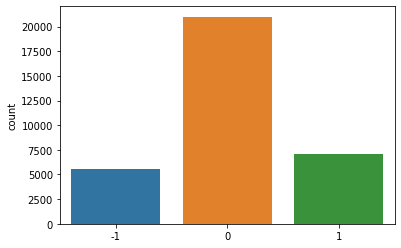

In [0]:
import seaborn as sns
sns.countplot(y_pred)

#### Get the final results

In [0]:
df_pred['sentiment'] = y_pred
df_pred

,user_id,created_at,content,like_num,repost_num,comment_num,sentiment
0,1681872675,2020-01-20 08:10,发现 满屏 都 是 关于 新冠 肺炎 在 全国 各地 传播 的 新闻 虽 可控 可防 但 还...,0,0,0,-1
1,1306052985,2020-01-20 08:21,三条 通报 的 时间 点好 一致 首发 症状 大多 为 发热 咳嗽 胸闷 呼吸困难 这新冠 ...,0,0,0,0
2,2218332387,2020-01-20 09:08,关于 最近 很 猖狂 的 新冠型 肺炎 病毒 我们 紧急召开 了 第二届 家庭 会议 ...,0,1,3,0
3,2167644005,2020-01-20 13:49,有过 上海 世博会 的 经历 各种 排队 不是 个 事儿 。 有过 非典型 肺炎 的 经验 ...,0,0,0,0
4,7339096067,2020-01-20 18:34,星座 仔细 想想 自打 112 土冥合 相 之后 就 没什么 好消息 啊 叹气 更 ...,4,0,7,0
...,...,...,...,...,...,...,...
36650,1804649801,2020-03-09 23:59,西班牙 新冠 肺炎 确诊 病例 已达 999 例 愿 平安 🙏 🙏,1,0,0,0
36651,5344250889,2020-03-09 23:59,巩固 拓展 决胜 态势 坚决 打赢 两场 硬仗 徐衣显 在 这场 专题 新闻 发布会 上 透...,0,0,0,0
36652,5094666244,2020-03-09 23:59,钟南山 院士 公布 研究 最新 成果 钟南山 院士 已 开发 快速 检测 试纸 恒温 扩...,0,2,0,0
36653,5109213891,2020-03-09 23:59,李克强 主持 召开 中央 应对 新冠 肺炎 疫情 工作 领导 小组会议 3 月 9 日 中共...,0,0,0,0


In [0]:
df_train.rename(columns={'manually_label':'sentiment'},inplace=True)

In [0]:
df_final_result = pd.concat([df_train,df_pred])
df_final_result = df_final_result.sort_index()

In [0]:
df_final_result

,user_id,created_at,content,like_num,repost_num,comment_num,sentiment
0,1681872675,2020-01-20 08:10,发现 满屏 都 是 关于 新冠 肺炎 在 全国 各地 传播 的 新闻 虽 可控 可防 但 还...,0,0,0,-1
1,1306052985,2020-01-20 08:21,三条 通报 的 时间 点好 一致 首发 症状 大多 为 发热 咳嗽 胸闷 呼吸困难 这新冠 ...,0,0,0,0
2,2218332387,2020-01-20 09:08,关于 最近 很 猖狂 的 新冠型 肺炎 病毒 我们 紧急召开 了 第二届 家庭 会议 ...,0,1,3,0
3,2167644005,2020-01-20 13:49,有过 上海 世博会 的 经历 各种 排队 不是 个 事儿 。 有过 非典型 肺炎 的 经验 ...,0,0,0,0
4,7339096067,2020-01-20 18:34,星座 仔细 想想 自打 112 土冥合 相 之后 就 没什么 好消息 啊 叹气 更 ...,4,0,7,0
...,...,...,...,...,...,...,...
36650,1804649801,2020-03-09 23:59,西班牙 新冠 肺炎 确诊 病例 已达 999 例 愿 平安 🙏 🙏,1,0,0,0
36651,5344250889,2020-03-09 23:59,巩固 拓展 决胜 态势 坚决 打赢 两场 硬仗 徐衣显 在 这场 专题 新闻 发布会 上 透...,0,0,0,0
36652,5094666244,2020-03-09 23:59,钟南山 院士 公布 研究 最新 成果 钟南山 院士 已 开发 快速 检测 试纸 恒温 扩...,0,2,0,0
36653,5109213891,2020-03-09 23:59,李克强 主持 召开 中央 应对 新冠 肺炎 疫情 工作 领导 小组会议 3 月 9 日 中共...,0,0,0,0


In [0]:
df_final_result.to_csv('final_sentiment_result_new.csv')